In [22]:
from utils.basics import RESOURCES_NIMARE_DIR, ATLASES_DIR, FB_400ROI_ATLAS_NAME, PRJ_DIR, SCRIPTS_DIR, RESOURCES_NBS_DIR
from utils.plotting import create_graph_from_matrix
import os
import os.path as osp
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
import nibabel as nib
from nilearn.image import load_img
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import masking
import numpy as np
import pandas as pd
from utils.basics import FB_400ROI_ATLAS_PATH
import subprocess
from nimare.decode import discrete
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap

import getpass
from datetime import datetime
from glob import glob

In [2]:
import wordcloud
print(wordcloud.__version__)

1.8.2.2


In [3]:
def my_orange_color_func(dictionary):
    def my_orange_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Oranges',100).as_hex()
        return color_list[freq_as_int]
    return my_orange_color_func_inner
def my_blue_color_func(dictionary):
    def my_blue_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Blues',100).as_hex()
        return color_list[freq_as_int]
    return my_blue_color_func_inner

# 1. NiMare Setup
## 1.1. Folder Setup

In [4]:
vocab = 'LDA50'
ATLAS_NAME = FB_400ROI_ATLAS_NAME

In [31]:
VOCAB_DIR            = osp.join(RESOURCES_NIMARE_DIR,vocab)
METAMAPS_ORIG_DIR    = osp.join(VOCAB_DIR,"meta-analyses-orig")  # where to save meta-analysis maps
METAMAPS_RPI_DIR     = osp.join(VOCAB_DIR,"meta-analyses-RPI")  # where to save meta-analysis maps

ns_dset_path         = osp.join(VOCAB_DIR, f"neurosynth_dataset_{vocab}.pkl.gz")
ns_dset_mask_path    = osp.join(VOCAB_DIR, f"neurosynth_dataset_{vocab}_mask.nii")
#ns_dset_mask_path    = osp.join(METAMAPS_ORIG_DIR, f"neurosynth_dataset_{vocab}_mask.nii")
#lda_model_path       = osp.join(VOCAB_DIR, f'lda_model.pkl.gz')

print('++ INFO: Resource Folder for NiMare Analyses                              : %s' % RESOURCES_NIMARE_DIR)
print('++ INFO: Folder for this vocabulary                                       : %s' % VOCAB_DIR)
print('++ INFO: Folder for meta-maps in original orientation as written by NiMare: %s' % METAMAPS_ORIG_DIR)
print('++ INFO: Folder for meta-maps in RPI orientation (the one our data has)   : %s' % METAMAPS_RPI_DIR)
print('++ ------------------------------------------------------------------------')
print('++ INFO: Path for NeuroSynth Dataset in NiMare format                     : %s' % ns_dset_path)
print('++ INFO: Path for NeuroSynth Dataset mask                                 : %s' % ns_dset_mask_path)
#print('++ INFO: Path for locally trained LDA model.                              : %s' % lda_model_path)

++ INFO: Resource Folder for NiMare Analyses                              : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare
++ INFO: Folder for this vocabulary                                       : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50
++ INFO: Folder for meta-maps in original orientation as written by NiMare: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig
++ INFO: Folder for meta-maps in RPI orientation (the one our data has)   : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI
++ ------------------------------------------------------------------------
++ INFO: Path for NeuroSynth Dataset in NiMare format                     : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50.pkl.gz
++ INFO: Path for NeuroSyn

In [6]:
# Create Empty Output Folders
# ===========================
print("++ INFO: Setting up all necessary folders")
for folder_path in [RESOURCES_NIMARE_DIR, VOCAB_DIR, METAMAPS_ORIG_DIR, METAMAPS_RPI_DIR]:
    if osp.exists(folder_path):
        print(" + WARNING: Removing folder [%s]" % folder_path)
        shutil.rmtree(folder_path)
    print(" + INFO: Generating/Regenerating output folder [%s]" % folder_path)
    os.mkdir(folder_path)

++ INFO: Setting up all necessary folders
 + WARNING: Removing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI]


## 1.2. Download Neurosynth 7 database

First, we need to download the Neurosynth database (version 7) for the 50 Topic Vocabulary

In [7]:
# Download NeuroSynth database
print("++ INFO: Fetching neurosynth dataset for this vocabulary...")
files = fetch_neurosynth(data_dir=VOCAB_DIR, version="7", overwrite=False, vocab=vocab, source="abstract")

INFO:nimare.extract.utils:Dataset created in /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth
INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('vocab-LDA50', 'source-abstract', 'data-neurosynth', 'version-7')]


++ INFO: Fetching neurosynth dataset for this vocabulary...


## 1.3. Convert Neurosynth Database to NiMare Dataset

Next, we need to convert it into a format NiMare can understand

In [8]:
%%time
# Convert to NiMare Dataset
neurosynth_db = files[0]
neurosynth_dset = convert_neurosynth_to_dataset(
        coordinates_file=neurosynth_db['coordinates'],
        metadata_file=neurosynth_db['metadata'],
        annotations_files=neurosynth_db['features'],
        )

CPU times: user 2min 41s, sys: 2.7 s, total: 2min 44s
Wall time: 2min 41s


To avoid having to do these two steps continously, we will save the NiMare version of the NeuroSynth Database to disk. If we need it again, we just have to load this file.

In [9]:
# Save the dataset as a pickle file to the Resources directory
print ("++ INFO: Saving NeuroSynth Dataset to disk: %s" % ns_dset_path)
neurosynth_dset.save(ns_dset_path)

++ INFO: Saving NeuroSynth Dataset to disk: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50.pkl.gz


As a sanity check, we print the labels for the first 10 topics and count how many topics in total are in the database.

In [11]:
# Extract Topic Names
topics_ORIG = neurosynth_dset.get_labels()
print('++ INFO: First few topics      : %s' % str(topics_ORIG[0:5]))
print('++ INFO: Total number of topics: %d' % len(topics_ORIG))

++ INFO: First few topics      : ['LDA50_abstract_weight__0_network_state_resting', 'LDA50_abstract_weight__1_anxiety_trait_personality', 'LDA50_abstract_weight__2_cerebellar_cerebellum_basal', 'LDA50_abstract_weight__3_cortex_anterior_cingulate', 'LDA50_abstract_weight__4_stimulus_time_repetition']
++ INFO: Total number of topics: 50


## 1.4. Extract Dset Mask

This is necessary to ensure that any dataset that we decode is sitting on the same space and grid that NiMare expects

In [32]:
nib.save(neurosynth_dset.masker.mask_img,ns_dset_mask_path)
print('++ INFO: Neurosynth Dataset mask saved to disk: %s' % ns_dset_mask_path)

++ INFO: Neurosynth Dataset mask saved to disk: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50_mask.nii


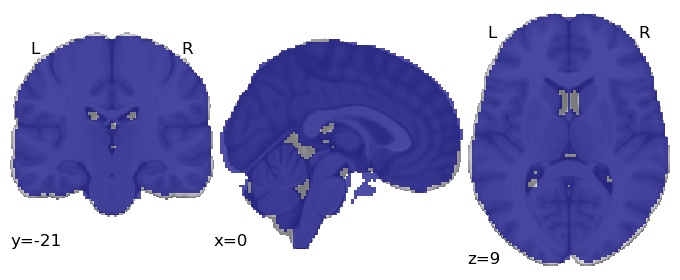

In [33]:
dset_mask = load_img(ns_dset_mask_path)
plot_roi(dset_mask, draw_cross=False);

In [34]:
command = f'''module load afni; \
              3dinfo -space -orient -header_name -header_line {ns_dset_mask_path}; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

space	=dim?	all_nms
MNI	LPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50_mask.nii


## 1.5. Make a mask restricted to GM ribbon for decoding

Although it is possible to decode using a full brain mask, this tends to not work so well becuase WM voxels cloud the correlations. 

First, we create a version of the atlas (Which covers the GM ribbon) in the same grid as the mask file provided by nimare. which as you can see above is a full brain mask

In [29]:
FB_400ROI_ATLAS_ORIG_GRID_FILE   = osp.join(FB_400ROI_ATLAS_PATH,f'{ATLAS_NAME}.nii.gz')
FB_400ROI_ATLAS_NIMARE_GRID_FILE = osp.join(RESOURCES_NIMARE_DIR,f'{ATLAS_NAME}_NiMareGrid.nii.gz')
command = f'''module load afni; \
              3dresample -overwrite -rmode NN \
                         -input  {FB_400ROI_ATLAS_ORIG_GRID_FILE} \
                         -prefix {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -master {ns_dset_mask_path}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('++ New File: %s' % FB_400ROI_ATLAS_NIMARE_GRID_FILE)

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13
++ New File: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Schaefer2018_400Parcels_7Networks_AAL2_NiMareGrid.nii.gz


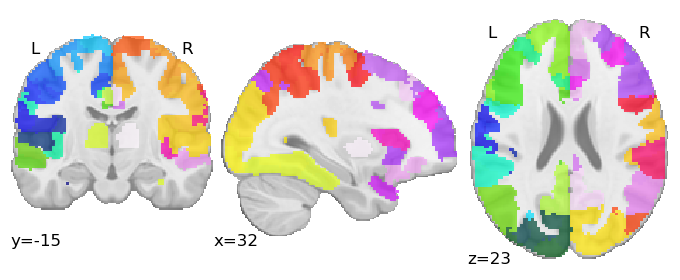

In [30]:
atlas_img = load_img(FB_400ROI_ATLAS_NIMARE_GRID_FILE)
plot_roi(atlas_img, draw_cross=False)

Create final mask for decoding (Neurosynth grid but restricted to the GM ribbon on which we computed the CPCAs)

In [35]:
NIMARE_DECODING_RIBBON_MASK = osp.join(RESOURCES_NIMARE_DIR,'NiMare_Decoding_Mask_GMribbon.nii.gz')
command = f'''module load afni; \
              3dcalc -overwrite \
                         -a {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -b {ns_dset_mask_path} \
                         -expr "step(a)*b" \
                         -prefix {NIMARE_DECODING_RIBBON_MASK}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NiMare_Decoding_Mask_GMribbon.nii.gz


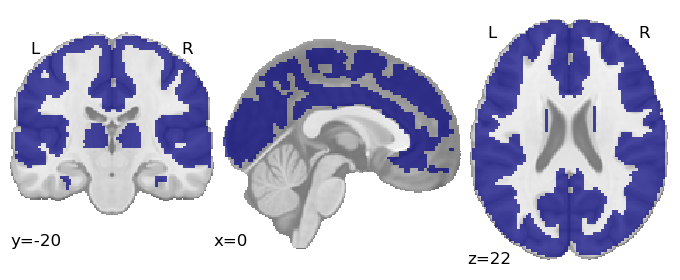

In [36]:
ribbon_mask_img = load_img(NIMARE_DECODING_RIBBON_MASK)
plot_roi(ribbon_mask_img, draw_cross=False)

# 1.5 Generate Nifti Files for Topic Maps in original orientation

It is advisable to have the topic maps available as .nii files in our local computer so that we can explore them in AFNI and also use them for computations outside the nimare environment.

Because this is a time intensive step, we will do it via a set of batch jobs. Next, we create the swarm files needed for this step.

In [12]:
username = getpass.getuser()
print('++ INFO: user working now --> %s' % username)

++ INFO: user working now --> javiergc


In [24]:
#user specific folders
#=====================
swarm_folder   = osp.join(PRJ_DIR,'SwarmFiles.{username}'.format(username=username))
logs_folder    = osp.join(PRJ_DIR,'Logs.{username}'.format(username=username))

swarm_path     = osp.join(swarm_folder,f'S15_NiMareTopics_{vocab}.SWARM.sh')
logdir_path    = osp.join(logs_folder, f'S15_NiMareTopics_{vocab}.logs')
print('++ INFO: swarm_path = %s' % swarm_path)
print('++ INFO: logs dir   = %s' % logdir_path)

++ INFO: swarm_path = /data/SFIMJGC_Introspec/2023_fc_introspection/SwarmFiles.javiergc/S15_NiMareTopics_LDA50.SWARM.sh
++ INFO: logs dir   = /data/SFIMJGC_Introspec/2023_fc_introspection/Logs.javiergc/S15_NiMareTopics_LDA50.logs


In [25]:
# create user specific folders if needed
# ======================================
if not osp.exists(swarm_folder):
    os.makedirs(swarm_folder)
    print('++ INFO: New folder for swarm files created [%s]' % swarm_folder)
if not osp.exists(logdir_path):
    os.makedirs(logdir_path)
    print('++ INFO: New folder for log files created [%s]' % logdir_path)

++ INFO: New folder for log files created [/data/SFIMJGC_Introspec/2023_fc_introspection/Logs.javiergc/S15_NiMareTopics_LDA50.logs]


In [34]:
# Open the file
swarm_file = open(swarm_path, "w")
# Log the date and time when the SWARM file is created
swarm_file.write('#Create Time: %s' % datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
swarm_file.write('\n')
# Insert comment line with SWARM command
swarm_file.write('#swarm -f {swarm_path} -g 32 -t 8 --partition quick,norm -b 5 --time 00:48:00 --merge-output --logdir {logdir_path}'.format(swarm_path=swarm_path,logdir_path=logdir_path))
swarm_file.write('\n')

# Insert one line per subject
for topic in topics_ORIG:
    topic = topic.replace(' ','-')
    swarm_file.write(f"export VOCAB={vocab} TOPIC={topic}; sh {SCRIPTS_DIR}/S15_NiMare_Create_TopicMaps.sh")
    swarm_file.write('\n')
swarm_file.close()

In [35]:
print(swarm_path)

/data/SFIMJGC_Introspec/2023_fc_introspection/SwarmFiles.javiergc/S15_NiMareTopics_LDA50.SWARM.sh


Submit this swarm file to generate nii files for all topics in vocabulary.

Once all jobs are completed, check that the topic maps are now available in ```/data/SFIMJGC_Introspec/2023_fc_introspecion/code/fc_intrisoection/nimare/LDA50/meta-analyses-orig```

In [13]:
command = f'''module load afni; \
              3dinfo -space -orient -header_name -header_line {ns_dset_mask_path} {VOCAB_DIR}/meta-analyses-orig/*language*specificity*; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig/LDA50_abstract_weight__37_language_reading_word_chi2_desc-specificity.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
space	=dim?	all_nms
MNI	LPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig/neurosynth_dataset_LDA50_mask.nii
ORIG	LPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig/LDA50_abstract_weight__37_language_reading_word_chi2_desc-specificity.nii.gz
ORIG	LPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig/LDA

In [14]:
from nilearn.plotting import view_img_on_surf

In [15]:
view_img_on_surf(osp.join(VOCAB_DIR,'meta-analyses-orig','LDA50_abstract_weight__37_language_reading_word_z_desc-specificity.nii.gz'))

# 1.6 Flip them to RPI 

Here, we are gonna do some "AFNI magic" to generate the same maps with a different orientation (RPI), so that they completely match our data. This is needed so that both AFNI and Python see the correct orientation when trying to match our data, with the NS maps

### First, let's flip the NS mask

In [61]:
ns_dset_mask_path_RPI = osp.join(METAMAPS_RPI_DIR,f'neurosynth_dataset_{vocab}_mask.nii')
command = f'''module load afni; \
              if [ ! -d {METAMAPS_RPI_DIR} ]; then mkdir {METAMAPS_RPI_DIR}; fi; \
              echo "hello"; \
              3dLRflip -LR -overwrite -prefix {ns_dset_mask_path_RPI} {ns_dset_mask_path}; \
              3drefit -orient RPI -space MNI {ns_dset_mask_path_RPI}; \
           '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

hello
++ processing /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50_mask.nii ...
++ 3drefit: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/neurosynth_dataset_LDA50_mask.nii
 + changing orientation codes
 + loading and re-writing dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/neurosynth_dataset_LDA50_mask.nii (/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/neurosynth_dataset_LDA50_mask.nii in NIFTI storage)
++ 3drefit processed 1 datasets


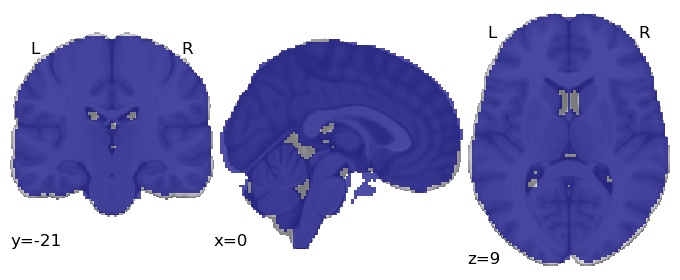

In [62]:
dset_mask = load_img(ns_dset_mask_path_RPI)
plot_roi(dset_mask, draw_cross=False);

In [63]:
command = f'''module load afni; \
              3dinfo -space -orient -header_name -header_line {ns_dset_mask_path_RPI}; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

space	=dim?	all_nms
MNI	RPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/neurosynth_dataset_LDA50_mask.nii


### Second,  let's flip the maps using a bash script that we generate here first and then we run also through the notebook.

Let's get a list of all the maps we want to transform. Becuase reverse-inference is based on the ```z_desc-specificity``` maps, we will only manipulate these to save time and disk space.

In [64]:
nimare_metamaps_orig        = sorted(glob(os.path.join(METAMAPS_ORIG_DIR, f"{vocab}_*z_desc-specificity.nii.gz")))
print(len(nimare_metamaps_orig))

50


In [65]:
#Path to script that will generate the corrected version of the meta-analytic maps
nimare_flip_metamaps_script_path = osp.join(SCRIPTS_DIR,'S15b_NiMare_Flip_TopicMaps.{vocab}.sh'.format(vocab=vocab))
print (nimare_flip_metamaps_script_path)

/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/bash/S15b_NiMare_Flip_TopicMaps.LDA50.sh


In [67]:
nimare_flip_metamaps_script = open(nimare_flip_metamaps_script_path, "w")
nimare_flip_metamaps_script.write('# Script to create flipped version of NiMare outputs\n')
nimare_flip_metamaps_script.write('module load afni\n')
nimare_flip_metamaps_script.write('\n')
nimare_flip_metamaps_script.write('set -e\n')
nimare_flip_metamaps_script.write('\n')
nimare_flip_metamaps_script.write('# Create output folder (if needed)\n')
nimare_flip_metamaps_script.write('if [ ! -d {out_folder} ]; then mkdir {out_folder}; fi\n\n'.format(out_folder=METAMAPS_RPI_DIR))
for orig_path in nimare_metamaps_orig:
    orig_file = osp.basename(orig_path)
    #orig_file = orig_file.replace(' ','\ ')
    new_path  = osp.join(METAMAPS_RPI_DIR,orig_file)
    #new_path  = new_path.replace(' ','-')
    nimare_flip_metamaps_script.write('3dLRflip -LR -overwrite -prefix "{out_file}" "{in_file}"\n'.format(in_file=orig_path, out_file=new_path))
    nimare_flip_metamaps_script.write('3drefit -orient RPI -space MNI "{in_file}"\n'.format(in_file=new_path))
    nimare_flip_metamaps_script.write('3dresample -overwrite -master {master_path} -input "{in_file}" -prefix "{out_file}"\n\n'.format(master_path = ns_dset_mask_path_RPI,
                                                                                                                               in_file = new_path,
                                                                                                                               out_file = new_path))
nimare_flip_metamaps_script.close()

Now, open a terminal and run the script

In [106]:
command = f'''module load afni; \
              3dinfo -space -orient -header_name -header_line {VOCAB_DIR}/meta-analyses-RPI/*language*specificity*; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

space	=dim?	all_nms
MNI	RPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/LDA50_abstract_weight__37_language_reading_word_z_desc-specificity.nii.gz
MNI	RPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/LDA50_abstract_weight__46_hemisphere_language_stroke_z_desc-specificity.nii.gz


In [70]:
view_img_on_surf(osp.join(VOCAB_DIR,'meta-analyses-RPI','LDA50_abstract_weight__37_language_reading_word_z_desc-specificity.nii.gz'))

### Third, let's create a GM restricted mask to be used in all decoding efforts (in RPI format)

As we can see, although we have ensured the same orient and space, the grid is still differnet between our atlas and the nimare mask

In [71]:
FB_400ROI_ATLAS_ORIG_GRID_FILE   = osp.join(FB_400ROI_ATLAS_PATH,f'{ATLAS_NAME}.nii.gz')
command = f'''module load afni; \
              3dinfo -space -orient -n4 -d3 -same_all_grid -header_name -header_line {ns_dset_mask_path_RPI} {FB_400ROI_ATLAS_ORIG_GRID_FILE}; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

space	=dim?	Nj	Nk	Nt	Nvi	Dk	Di_Dj_Dk	Oi	=ornt?	=cent?	=obl?	sDval	Dval	all_nms
MNI	RPI	91	109	91	1	2.000000	-2.000000	2.000000	0	1	1	0	1	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/neurosynth_dataset_LDA50_mask.nii
MNI	RPI	74	95	79	1	2.000000	-2.000000	2.000000	0	1	1	0	1	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/atlases/Schaefer2018_400Parcels_7Networks_AAL2/Schaefer2018_400Parcels_7Networks_AAL2.nii.gz


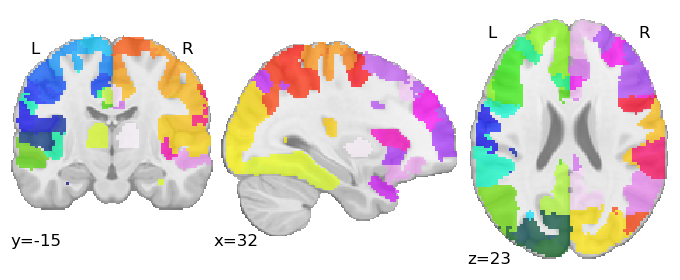

In [120]:
plot_roi(FB_400ROI_ATLAS_ORIG_GRID_FILE, draw_cross=False)

To correct that, we need to run 3dresample using as input the atlas, and the RPI corrected version of the data

In [74]:
FB_400ROI_ATLAS_NIMARE_GRID_FILE = osp.join(METAMAPS_RPI_DIR,f'{ATLAS_NAME}_NiMareGrid.nii.gz')
command = f'''module load afni; \
              3dresample -overwrite -rmode NN \
                         -input  {FB_400ROI_ATLAS_ORIG_GRID_FILE} \
                         -prefix {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -master {ns_dset_mask_path_RPI}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13


After the correction, everything is now on the same grid, space and orientation

In [75]:
command = f'''module load afni; \
              3dinfo -space -orient -n4 -d3 -same_all_grid -header_name -header_line {ns_dset_mask_path_RPI} {FB_400ROI_ATLAS_NIMARE_GRID_FILE}; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

space	=dim?	Nj	Nk	Nt	Nvi	Dk	Di_Dj_Dk	Oi	=ornt?	=cent?	=obl?	sDval	Dval	all_nms
MNI	RPI	91	109	91	1	2.000000	-2.000000	2.000000	1	1	1	1	1	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/neurosynth_dataset_LDA50_mask.nii
MNI	RPI	91	109	91	1	2.000000	-2.000000	2.000000	1	1	1	1	1	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/Schaefer2018_400Parcels_7Networks_AAL2_NiMareGrid.nii.gz


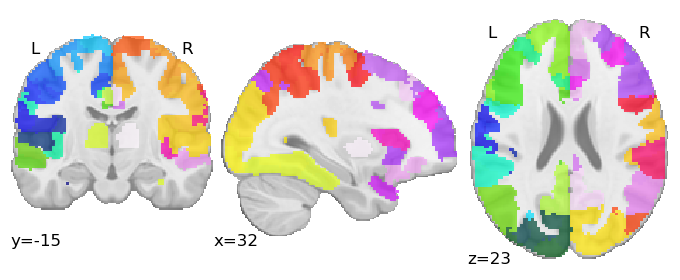

In [76]:
atlas_img = load_img(FB_400ROI_ATLAS_NIMARE_GRID_FILE)
plot_roi(atlas_img, draw_cross=False)

### Forth, we create the final decoding mask that only looks at GM voxels

In [77]:
NIMARE_DECODING_RIBBON_MASK = osp.join(METAMAPS_RPI_DIR,'NiMare_Decoding_Mask_GMribbon.nii.gz')
command = f'''module load afni; \
              3dcalc -overwrite \
                         -a {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -b {ns_dset_mask_path_RPI} \
                         -expr "step(a)*b" \
                         -prefix {NIMARE_DECODING_RIBBON_MASK}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NiMare_Decoding_Mask_GMribbon.nii.gz


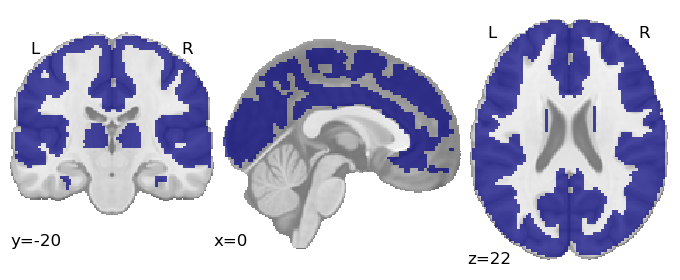

In [78]:
ribbon_mask_img = load_img(NIMARE_DECODING_RIBBON_MASK)
plot_roi(ribbon_mask_img, draw_cross=False)

# 2. Extract ROIs with highest degree for both NBS contrasts

# 2.1. Load Atlas Information so that we can annotate Pandas Dataframes

In [18]:
NBS_THRESHOLD        = 'NBS_3p1'

In [19]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)

## 2.2. Load NBS Results

In [23]:
NBS_constrasts = {}

Load the connections that are significantly stronger for the contrast: $$Image-Pos-Others > Surr-Neg-Self$$

In [24]:
#data_f1GTf2 = np.loadtxt(f'/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_CL02_Results/NBS_CL02_Image-Pos-Others_gt_Surr-Neg-Self.edge')
data_f1GTf2 = np.loadtxt(osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'All_Scans','NBS_CL02_Results',NBS_THRESHOLD,'NBS_CL02_Image-Pos-Others_gt_Surr-Neg-Self.edge'))
NBS_constrasts['f1GTf2'] = pd.DataFrame(data_f1GTf2,
                           index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                           columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
del data_f1GTf2

Load the connections that are significantly stronger for the contrast: $$Surr-Neg-Self > Image-Pos-Others$$

In [25]:
#data_f2GTf1 = np.loadtxt(f'/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_CL02_Results/NBS_CL02_Surr-Neg-Self_gt_Image-Pos-Others.edge')
data_f2GTf1 = np.loadtxt(osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'All_Scans','NBS_CL02_Results',NBS_THRESHOLD,'NBS_CL02_Surr-Neg-Self_gt_Image-Pos-Others.edge'))
NBS_constrasts['f2GTf1'] = pd.DataFrame(data_f2GTf1,
                           index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                           columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
del data_f2GTf1

## 2.3. Create Graph Models needed to compute Degree

In [26]:
%%time
NBS_Gs,NBS_Gatts = {},{}
for contrast in NBS_constrasts.keys():
    # Create Graph Model
    NBS_Gs[contrast],NBS_Gatts[contrast]      = create_graph_from_matrix(NBS_constrasts[contrast])
    NBS_Gatts[contrast] =  NBS_Gatts[contrast].set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).sort_index(level='ROI_ID')
N_rois = NBS_Gatts[contrast].shape[0]
print('++ INFO: Number of ROIs: %d' % N_rois)

++ INFO: Number of ROIs: 380
CPU times: user 199 ms, sys: 2.32 ms, total: 201 ms
Wall time: 201 ms


## 2.4. Write Graph Metric-per-ROI Results to disk as NifTi Files

We load the atlas (the version on the grid that aligns with NiMare) as a vector.

In [38]:
atlas_vector = masking.apply_mask(FB_400ROI_ATLAS_NIMARE_GRID_FILE, dset_mask)
print('++ INFO: Atlas Dimensions as a vector = %s' % str(atlas_vector.shape))

++ INFO: Atlas Dimensions as a vector = (228483,)


++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f1GTf2_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f1GTf2_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f1GTf2_Page_Rank.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f2GTf1_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f2GTf1_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f2GTf1_Page_Rank.nii]
CPU times: user 13.4 s, sys: 1.37 s, total: 14.8 s
Wall time: 13.5 s


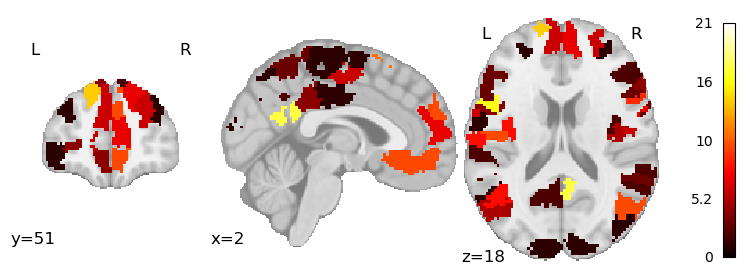

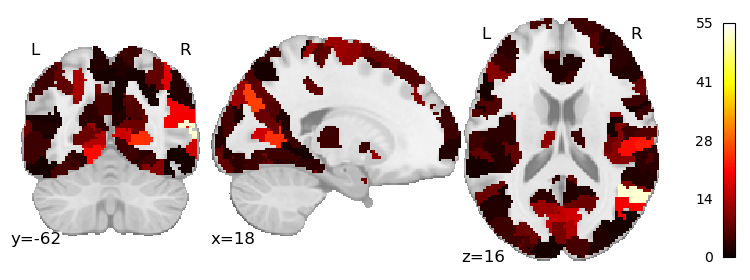

In [39]:
%%time
for contrast in NBS_constrasts.keys():
    for metric in ['Degree','Eigenvector_Centrality','Page_Rank']:
        # Create Empty Vector with same dimensions as atlas
        output_vector = np.zeros(atlas_vector.shape)
        # For each ROI extract the Graph Metric of interest
        for hm,nw,roi_name,roi_id,rgb in NBS_Gatts[contrast].index:
            output_vector[atlas_vector==roi_id] = NBS_Gatts[contrast].loc[(hm,nw,roi_name,roi_id,rgb),metric]
        # Write to disk just in case we want to look at it later
        output_img = masking.unmask(output_vector,dset_mask)
        output_path = osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{contrast}_{metric}.nii')
        output_img.to_filename(output_path)
        print('++ INFO: File written to disk [%s]' % output_path)
        if metric == 'Degree':
            plot_stat_map(output_path, draw_cross=False)

## 2.5. Also write file for the top degree ROI for each contrast (this is the one we will decode)

In [40]:
for contrast in NBS_constrasts.keys():
    input_path = osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{contrast}_Degree.nii')
    output_path = osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{contrast}_Degree_TopROI.nii')
    input_img  = load_img(input_path)
    top_degree_value = int(input_img.get_fdata().max())
    command = f'''module load afni; \
                  3dcalc -overwrite -a {input_path} -expr "equals(a,{top_degree_value})" -prefix {output_path}'''
    output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f1GTf2_Degree.nii to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f1GTf2_Degree_TopROI.nii
[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_f2GTf1_Degree.nii to FLOAT32
     Warnin

# 3. Preparations for WordCloud & ROI plot generation

Neurosynth topics and terms contain words that are not necessarily that meaningful when looking for relationships to cognitive processes. Examples of such words include those about anatomical structures, anatomical location, tissue types, imaging modalities, etc. We will remove those prior to generating wordclouds

In [41]:
my_stopwords = list(STOPWORDS) + ['resonance','magnetic','medial','lateral','dorsal','ventral','anterior','posterior','primary','secondary',
                                  'contralateral','prefrontal','temporal','occipital','parietal','frontal','network','cortex',
                                  'sii','mns','neuron','pre','md','gm','volume','matter','white','gray','hemispheric','state','mpfc','dmn','default',
                                  'fc','rest', 'temporoparietal','hippocampus','insula','premotor','supplementary','resting']

In this study we work with the 50 Topic dictionary. Each topic is associated with a set of terms that appear in unison in the neuroimaing literature. The next cell gathers the 40 top terms associated with each topic. We will only pick only those assoicated with topics that show significant correlations with our ROIs later when generating wordclouds. For now we load them all and have then ready on a pandas dataframe.

In [42]:
path            = osp.join(VOCAB_DIR,'neurosynth',f'data-neurosynth_version-7_vocab-{vocab}_keys.tsv')
words_per_topic = pd.read_csv(path, sep='\t', header=None)
words_per_topic.index = neurosynth_dset.get_labels()
words_per_topic.index.name = 'Topic Label'
words_per_topic.columns = ['Topic ID','Unknown','Terms']
words_per_topic.head(5)

Topic ID  Unknown  \
Topic Label                                                             
LDA50_abstract_weight__0_network_state_resting             0  0.06871   
LDA50_abstract_weight__1_anxiety_trait_personality         1  0.02725   
LDA50_abstract_weight__2_cerebellar_cerebellum_...         2  0.04606   
LDA50_abstract_weight__3_cortex_anterior_cingulate         3  0.08111   
LDA50_abstract_weight__4_stimulus_time_repetition          4  0.06010   

                                                                                                Terms  
Topic Label                                                                                            
LDA50_abstract_weight__0_network_state_resting      network state resting default dmn mode intrins...  
LDA50_abstract_weight__1_anxiety_trait_personality  anxiety trait personality high scores individu...  
LDA50_abstract_weight__2_cerebellar_cerebellum_...  cerebellar cerebellum basal ganglia thalamus m...  
LDA50_abstract_weight__3_cortex_anterior_cingulate  cortex anterior cingulate insula acc dorsal po...  
LDA50_abstract_weight__4_stimulus_time_repetition   stimulus time repetition priming response pres...

Finally, we will want to show the ROI with the highest degree on each direction of the contrast. To make nilearn plot the countour in black color, we need to generate a fake colormap with black being the first color.

In [43]:
roi_cmap = LinearSegmentedColormap.from_list('black',['#000000','#ffffff'],10)

# 4. ROI decoding on location with highest degree

## 4.1. Images-Pos-Others > Surr-Neg-Self

### 4.1.1. Load the target ROI

In [44]:
top_degree_roi_path =  osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_f1GTf2_Degree_TopROI.nii')
top_degree_roi      = load_img(top_degree_roi_path)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


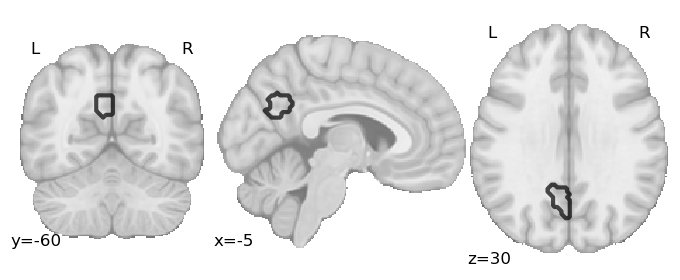

In [45]:
f = plot_roi(top_degree_roi,draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=[-5,-60,30], view_type='contours', cmap=roi_cmap)

In [46]:
f.savefig('./figures/S15a_f1GTf2_TopDegree_ROI.png')

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [47]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 888 stduies


### 4.1.3. Decode using the Chi-Method

In [48]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nimare/decode/discrete.py:600: RuntimeWarning: invalid value encountered in divide
  p_selected_g_noterm = n_selected_noterm / n_noterm


In [49]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


pForward   zForward  \
Term                                                                          
LDA50_abstract_weight__8_mpfc_social_medial         1.000000e+00  -0.000000   
LDA50_abstract_weight__0_network_state_resting      6.064763e-32  11.762856   
LDA50_abstract_weight__28_social_empathy_moral      1.720056e-06  -4.783807   
LDA50_abstract_weight__33_memory_retrieval_enco...  3.094254e-13   7.290230   
LDA50_abstract_weight__41_imagery_mental_events     1.463506e-09  -6.048335   
LDA50_abstract_weight__21_matter_volume_structural  9.324398e-10  -6.120565   
LDA50_abstract_weight__6_auditory_speech_temporal   1.444943e-17  -8.531474   

                                                    probForward      pReverse  \
Term                                                                            
LDA50_abstract_weight__8_mpfc_social_medial            0.080135  2.235502e-16   
LDA50_abstract_weight__0_network_state_resting         0.065948  2.489172e-08   
LDA50_abstract_weight__28_social_empathy_moral         0.072084  1.218098e-03   
LDA50_abstract_weight__33_memory_retrieval_enco...     0.066533  1.231463e-05   
LDA50_abstract_weight__41_imagery_mental_events        0.070584  3.024857e-02   
LDA50_abstract_weight__21_matter_volume_structural     0.055608  8.191912e-03   
LDA50_abstract_weight__6_auditory_speech_temporal      0.054815  3.974601e-02   

                                                    zReverse  probReverse  
Term                                                                       
LDA50_abstract_weight__8_mpfc_social_medial         8.208725     0.657782  
LDA50_abstract_weight__0_network_state_resting      5.574027     0.599819  
LDA50_abstract_weight__28_social_empathy_moral      3.234608     0.592491  
LDA50_abstract_weight__33_memory_retrieval_enco...  4.371942     0.585657  
LDA50_abstract_weight__41_imagery_mental_events     2.166820     0.579120  
LDA50_abstract_weight__21_matter_volume_structural -2.644056     0.412112  
LDA50_abstract_weight__6_auditory_speech_temporal  -2.056379     0.411534

### 4.1.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [50]:
if vocab != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [51]:
freqs_df = pd.Series(dtype=float)
if vocab == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [52]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [53]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [54]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

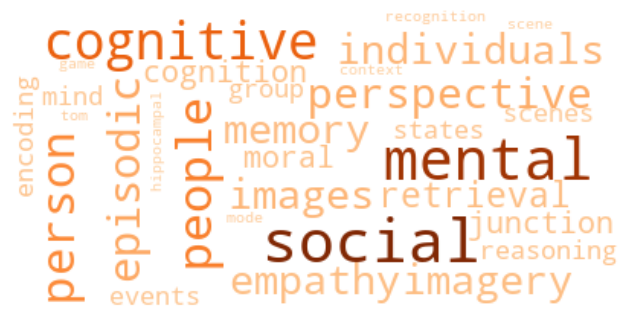

In [56]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'./figures/S15a_WordCloud_{NBS_THRESHOLD}_f1GTf2_TopDegree_NeuosynthDeconding.png')

## 4.2. Surr-Neg-Self > Images-Pos-Others

### 4.2.1. Load the target ROI

In [57]:
top_degree_roi_path =  osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_f2GTf1_Degree_TopROI.nii')
top_degree_roi      = load_img(top_degree_roi_path)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


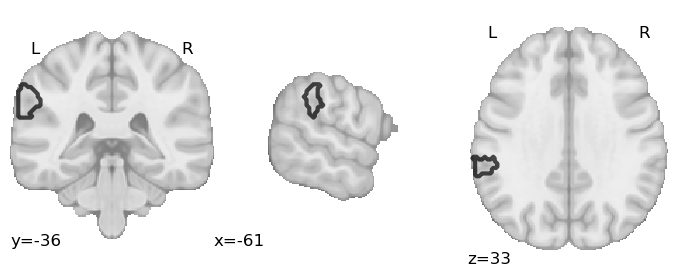

In [58]:
f = plot_roi(top_degree_roi,draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=[-61,-36,33], view_type='contours', cmap=roi_cmap)

In [59]:
f.savefig(f'./figures/S15a_{NBS_THRESHOLD}_f2GTf1_TopDegree_ROI.png')

### 4.2.2. Gather the studies with coordinates that overlap with the ROI

In [60]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 616 stduies


### 4.2.3. Decode using the Chi-Method

In [61]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

In [62]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


pForward  zForward  \
Term                                                                     
LDA50_abstract_weight__32_pain_somatosensory_st...  0.001526 -3.169599   
LDA50_abstract_weight__19_action_actions_observ...  0.060487 -1.877229   
LDA50_abstract_weight__17_motor_cortex_hand         0.000328  3.591875   
LDA50_abstract_weight__21_matter_volume_structural  0.000001 -4.841835   

                                                    probForward      pReverse  \
Term                                                                            
LDA50_abstract_weight__32_pain_somatosensory_st...     0.058304  1.095574e-08   
LDA50_abstract_weight__19_action_actions_observ...     0.051212  9.609248e-04   
LDA50_abstract_weight__17_motor_cortex_hand            0.045867  3.913115e-02   
LDA50_abstract_weight__21_matter_volume_structural     0.038144  3.126812e-02   

                                                    zReverse  probReverse  
Term                                                                       
LDA50_abstract_weight__32_pain_somatosensory_st...  5.715227     0.661216  
LDA50_abstract_weight__19_action_actions_observ...  3.301724     0.607766  
LDA50_abstract_weight__17_motor_cortex_hand         2.062805     0.569992  
LDA50_abstract_weight__21_matter_volume_structural -2.153644     0.402187

### 4.2.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [63]:
if vocab != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [64]:
freqs_df = pd.Series(dtype=float)
if vocab == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [65]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [66]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [67]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

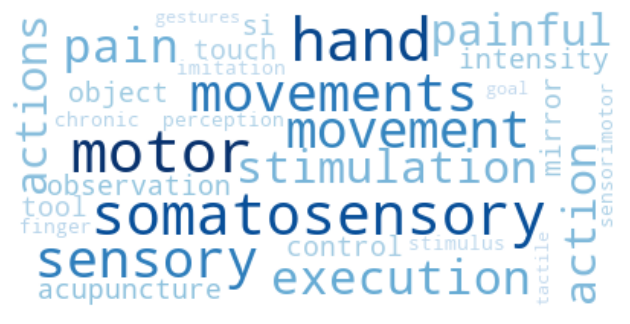

In [68]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'./figures/S14b_WordCloud_{NBS_THRESHOLD}_f2GTf1_TopDegree_NeuosynthDeconding.png')